In [8]:
import os

import networkx as nx
import numpy as np
import pandas as pd

from graspy.utils import import_graph, pass_to_ranks
from graspy.embed import OmnibusEmbed, ClassicalMDS
from graspy.cluster import GaussianCluster

import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [9]:
def get_dissimilarity(X, n_graphs, n_vertices):
    """
    Computes test statistics based on each pairs 

    Returns
    -------
    out : array-like, shape (n_graphs, n_graphs)
        A dissimilarity matrix based on Frobenous norms between pairs of
        graphs.
    """

    zhat = X.reshape(n_graphs, n_vertices, -1)

    out = np.zeros((n_graphs, n_graphs))
    for i in range(n_graphs):
        out[i] = np.linalg.norm(zhat - zhat[i], axis=(1, 2), ord='fro')

    return out

In [10]:
fmri_path = '../desikan_hnu1_fmri/'
fmris = os.listdir(fmri_path)

dmri_path = '../desikan_hnu1_dwi/'
dmris = os.listdir(dmri_path)

In [11]:
subjects = [s.split('_')[0] for s in dmris]
subjects_unique = list(set(subjects))

subjects_corrected = []

for subject in subjects_unique:
    fmri_tmp = [f for f in fmris if subject in f]
    fmri_sessions = [f.split('_')[1] for f in fmri_tmp]
    
    if len(fmri_sessions) == 10:
        subjects_corrected.append(subject)
        
subjects_corrected = sorted(subjects_corrected)

In [12]:
fmris = [f for f in fmris if f.split('_')[0] in subjects_corrected]
dmris = [f for f in dmris if f.split('_')[0] in subjects_corrected]

dmris = sorted(dmris)
fmris = sorted(fmris)

len(fmris), len(dmris)

(220, 220)

In [13]:
for idx in range(len(fmris)):
    f = fmris[idx].split('_')
    d = dmris[idx].split('_')
    
    assert f[0] == d[0]
    assert f[1] == d[1]

In [14]:
tmp1 = []
tmp2 = []

for subject in subjects_corrected:
    tmp1 += [subject + '-fmri'] * 10
    tmp2 += [subject + '-dmri'] * 10
    
subject_scan_labels = tmp1 + tmp2

tmp2 = []
tmp3 = []

for subject in subjects_corrected:
    tmp1 += [subject] * 10
    tmp2 += [subject] * 10

subject_labels = tmp2 + tmp3

In [15]:
N = 220

In [16]:
fmri_graphs = [np.load(fmri_path + f) for f in fmris]
dmri_graphs = [np.load(dmri_path + f) for f in dmris]

fmri_graphs = [pass_to_ranks(f) for f in fmri_graphs[:N]]
dmri_graphs = [pass_to_ranks(f) for f in dmri_graphs[:N]]

#graphs = fmri_graphs[:10] + dwi_graphs[:10] + fmri_graphs[10:] + dwi_graphs[10:]
graphs = fmri_graphs + dmri_graphs

len(fmri_graphs), len(dmri_graphs)

(220, 220)

## Multimodal, multigraph clustering

### Embedding the multimodal graphs all at once

Data summary
- subjects = 22
- fmris per subject = 10
- dmris per subject = 10
- total scans = 440

Desikan atlas
- num vertices = 70

In [39]:
omni = OmnibusEmbed(k=50)
omni.fit(graphs)

dissimilarity = omni.get_dissimilarity()

### T-semipar matrix shows blocks in modality.

F denotes graphs that are from fMRIs and D denotes graphs from DWIs. We see that fMRI graphs form a block and DWI graphs form another block.

We also see block structure within each modality, which refer to each subject.

In [68]:
labels = ["F"] * 220 + ["D"] * 220

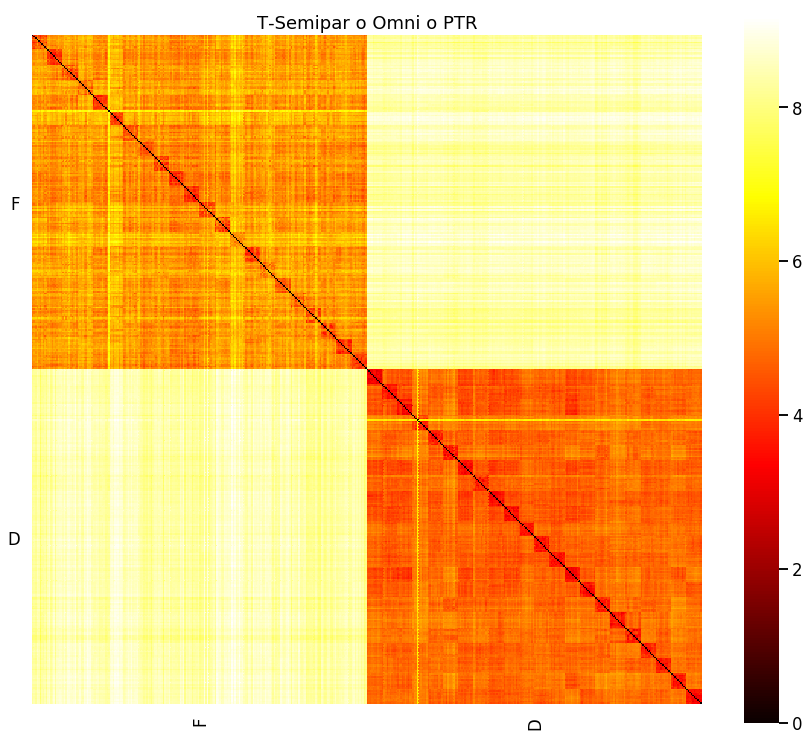

In [81]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 13))
    plot = sns.heatmap(dissimilarity, cmap='hot', square=True, xticklabels=labels, yticklabels=labels)
    plot.set_title("T-Semipar o Omni o PTR")
    

    
    for ind, label in enumerate(plot.get_xticklabels()):
        if (ind == 110) | (ind == 330):
            label.set_visible(True)
        else:
            label.set_visible(False)
            
    for ind, label in enumerate(plot.get_yticklabels()):
        if (ind == 110) | (ind == 330):
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    plot.xaxis.set_ticks_position('none')
    plot.yaxis.set_ticks_position('none')

In [41]:
cmds = ClassicalMDS(n_components=25)
X = cmds.fit_transform(dissimilarity)
X = np.fliplr(X)

### cMDS results show fMRIs and DWIs graphs tend to form its own cluster

When looking at combinations of dimension 1 and other dimensions, fMRI graphs and dMRI graphs are separated.

<Figure size 1080x1080 with 0 Axes>

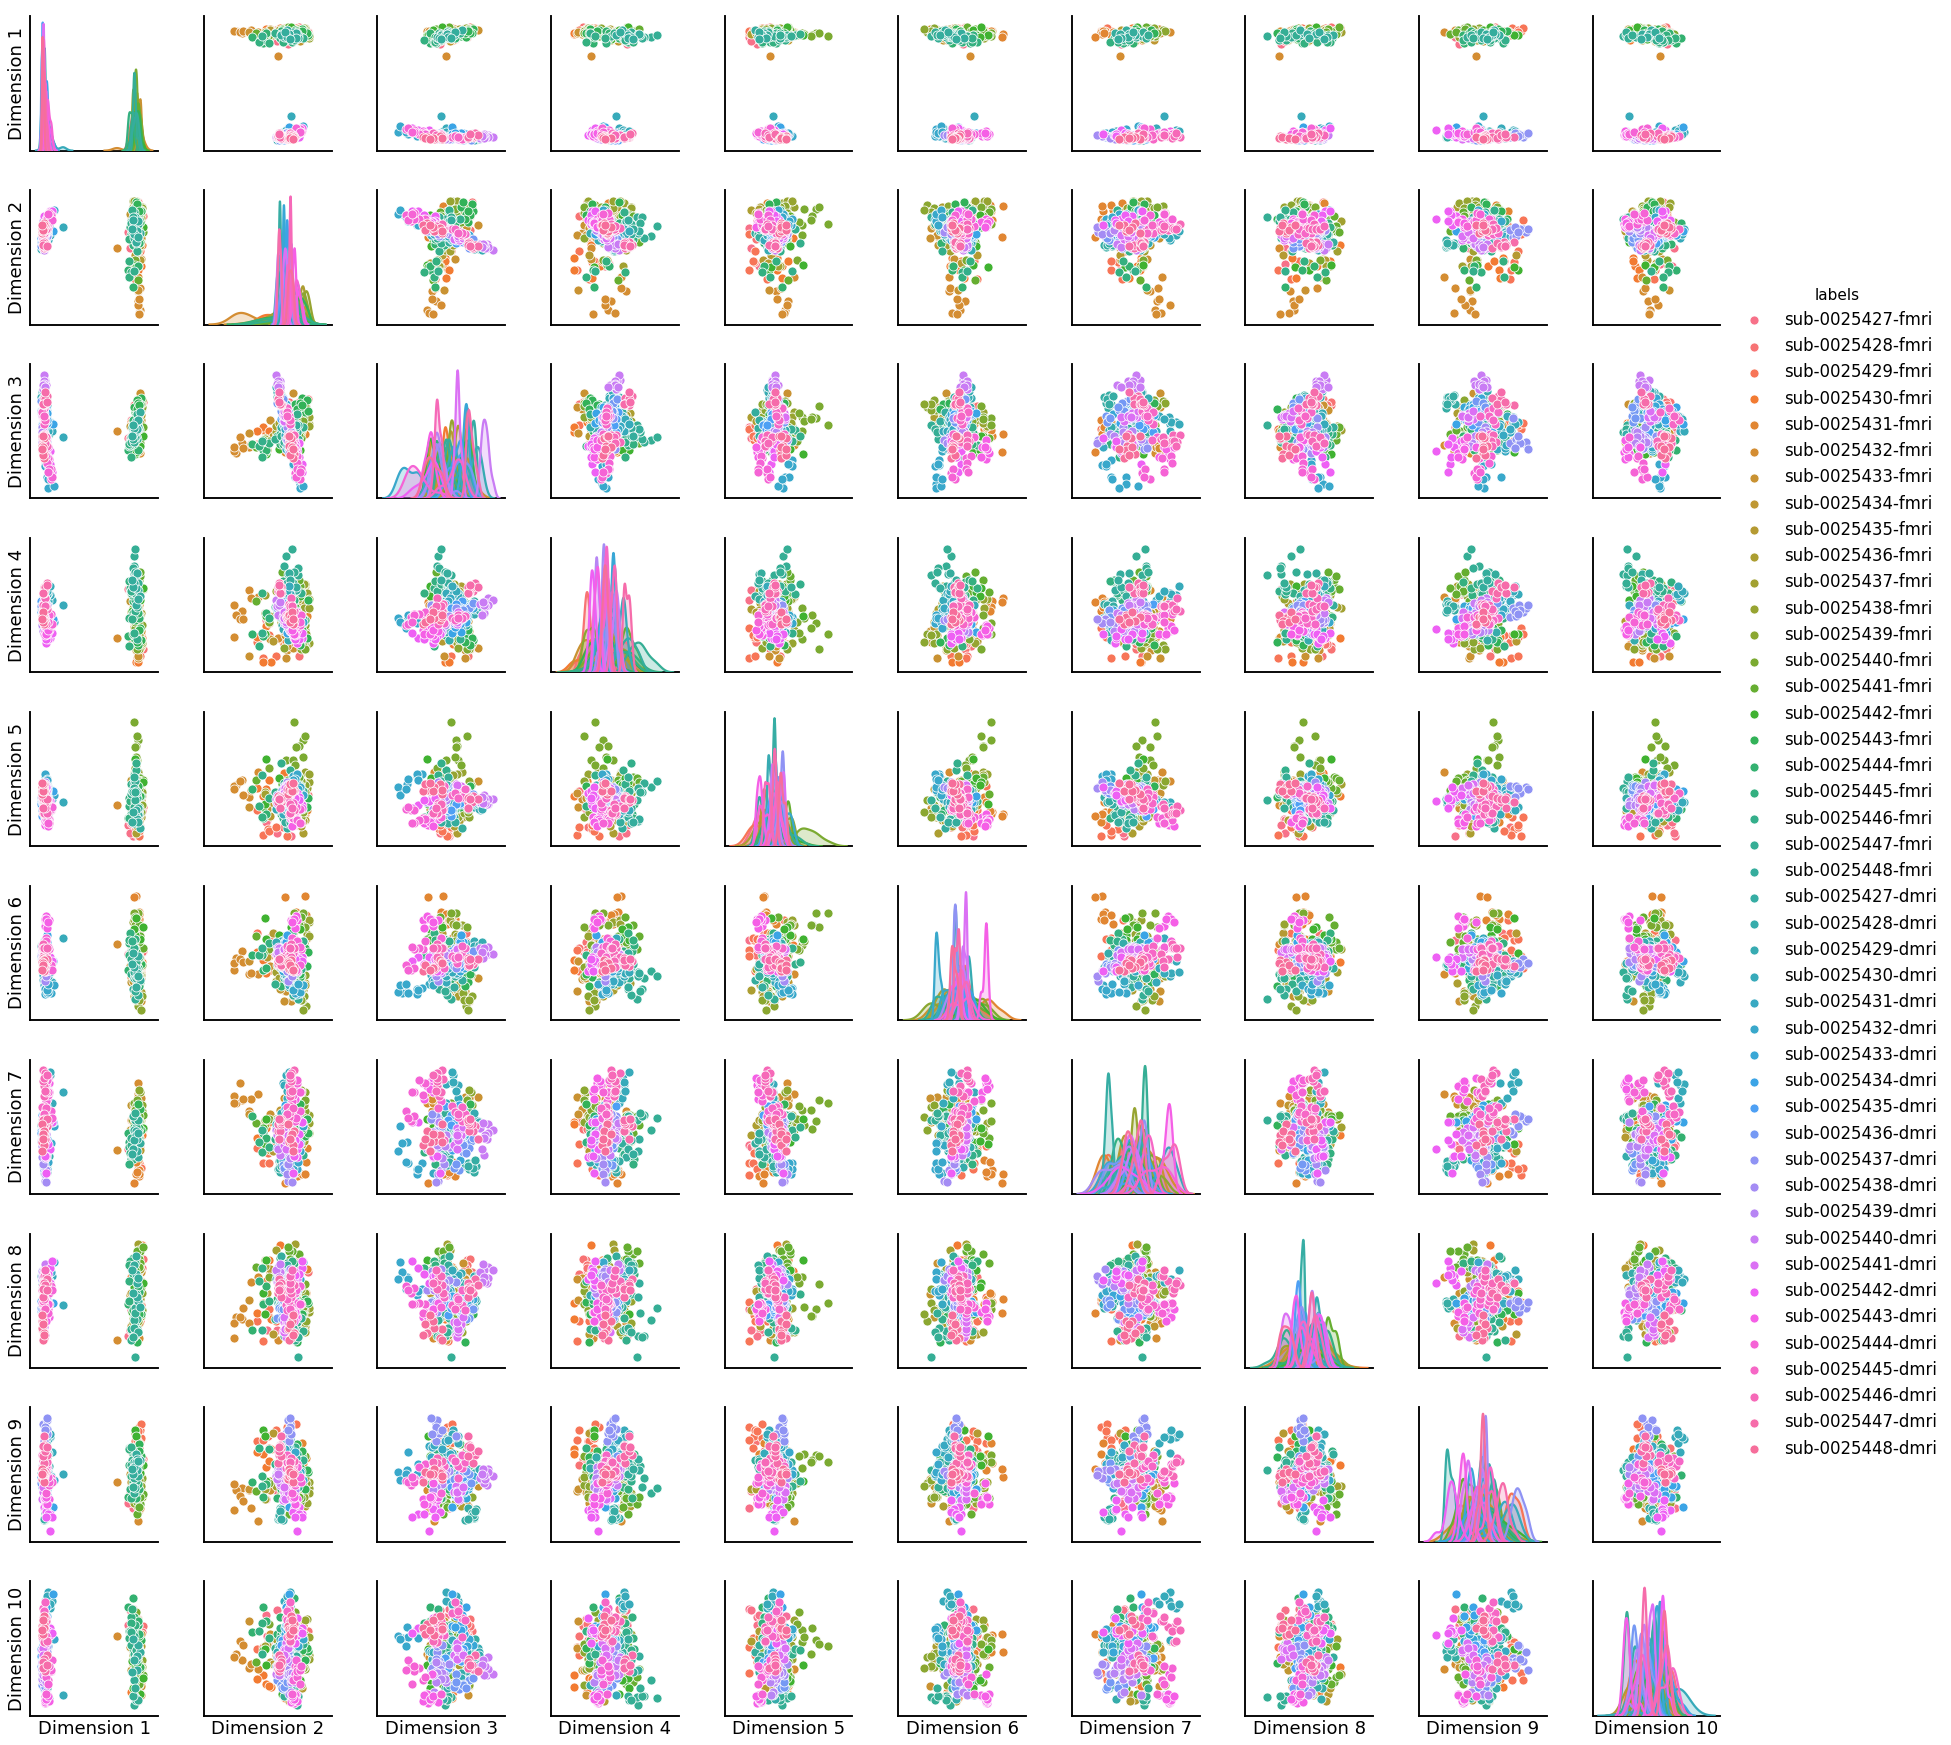

In [84]:
df_labels = pd.DataFrame(subject_scan_labels, columns=['labels'])
df_labels_ = pd.DataFrame(subject_labels, columns=['labels_'])
col_names =  ['Dimension {}'.format(i) for i in range(1, X.shape[1] + 1)]
df = pd.DataFrame(X, columns = col_names)
df = pd.concat([df_labels, df_labels_, df], axis = 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 15))
    pairs = sns.pairplot(df, hue = 'labels', vars=col_names[:10])
    pairs.set(xticklabels=[], yticklabels=[], yticks=[], xticks=[])
    #pairs.set_title("cMDS o T-Semipar o Omni o PTR")
    #pairs.set

### Removing the label information about modality shows no structure

<Figure size 1080x1080 with 0 Axes>

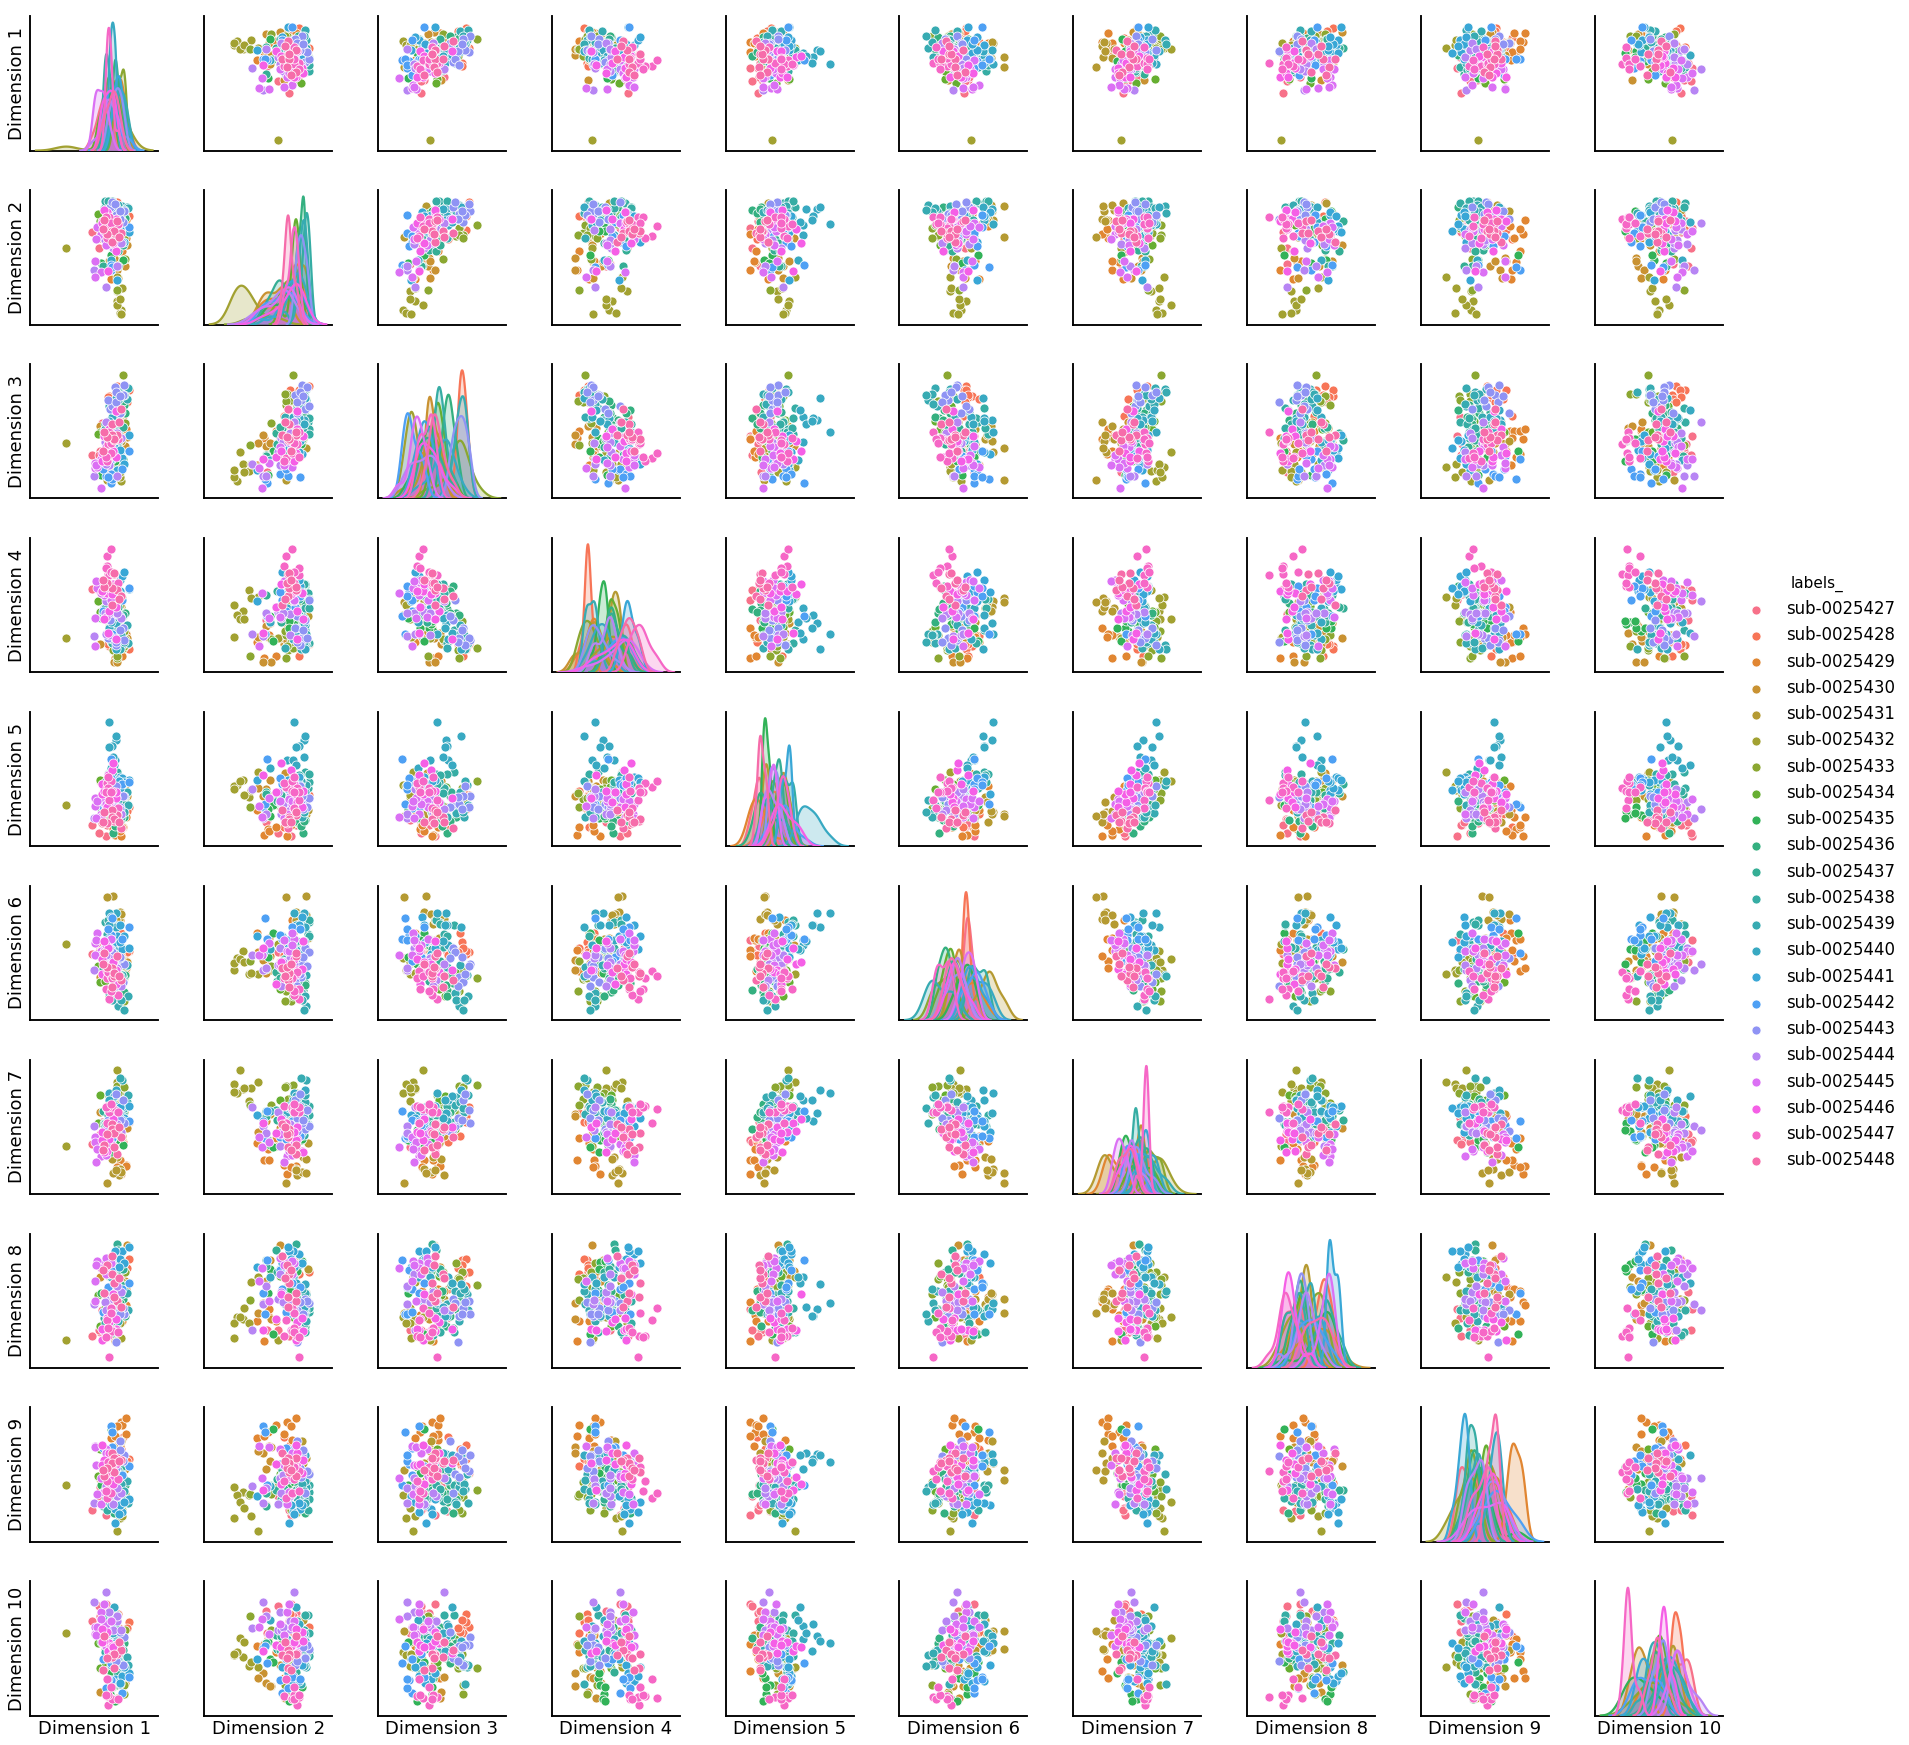

In [85]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 15))
    pairs = sns.pairplot(df, hue = 'labels_', vars=col_names[:10])
    pairs.set(xticklabels=[], yticklabels=[], yticks=[], xticks=[])

### ARI peaks at about 0.869 when num_clusters = 49

There are 44 unique labels. Each subject label is subdivided into fMRI and dMRI labels.

0.8696445993760252 49


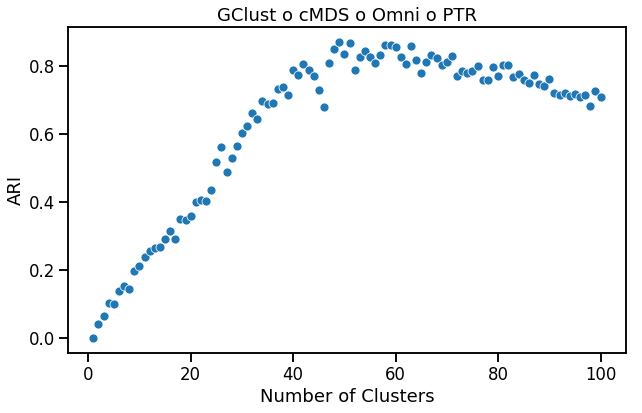

In [88]:
gclust = GaussianCluster(max_components = 100)
gclust.fit(X, subject_scan_labels)

aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o PTR')

### ARI peaks at 0.54 when num_clusters = 46

There are 22 unique labels, each corresponding to a subject.

0.5403490462152949 46


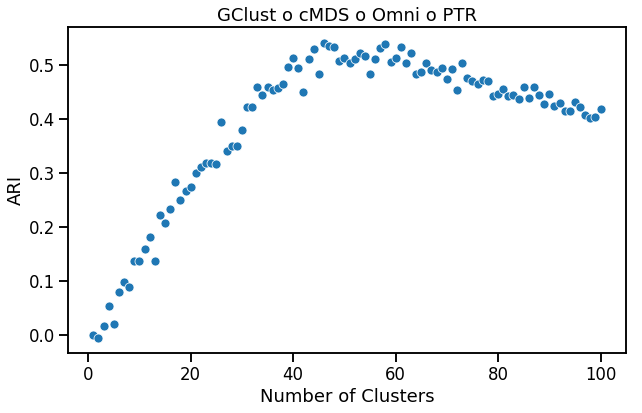

In [92]:
gclust = GaussianCluster(max_components = 100)
gclust.fit(X, subject_labels * 2)

aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o PTR')

## Try concatenating results from fMRI and DWIs

First we embed graphs from DWIs and fMRIs separately. Then we concatenate the resulting estimated latent position vectors

In [93]:
K = 50
omni = OmnibusEmbed(k=K)
dmri_hat = omni.fit_transform(dmri_graphs)

omni = OmnibusEmbed(k=K)
fmri_hat = omni.fit_transform(fmri_graphs)

Z_hat = np.hstack([fmri_hat, dmri_hat])
Z_hat.shape

(15400, 100)

In [94]:
dissimilarity = get_dissimilarity(Z_hat, 220, K*2)

In [95]:
dissimilarity.shape

(220, 220)

### T-semipar shows block structure based on subjects

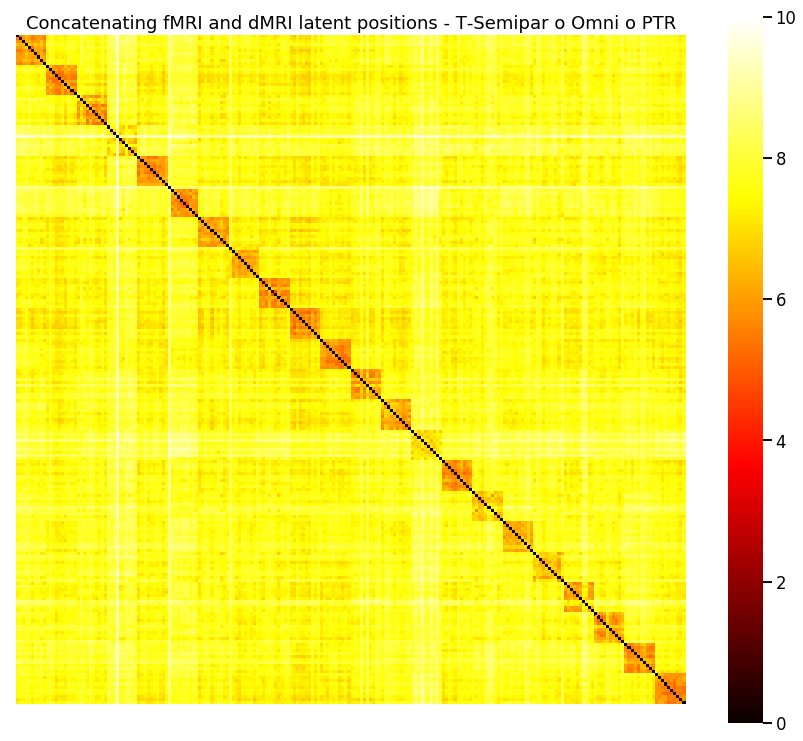

In [96]:
with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 13))
    plot = sns.heatmap(dissimilarity, cmap='hot', square=True, xticklabels=False, yticklabels=False)
    plot.set_title("Concatenating fMRI and dMRI latent positions - T-Semipar o Omni o PTR")

In [97]:
cmds = ClassicalMDS(n_components=25)
X = cmds.fit_transform(dissimilarity)
X = np.fliplr(X)

### cMDS o T-Semipar o Omni o PTR

<Figure size 1080x1080 with 0 Axes>

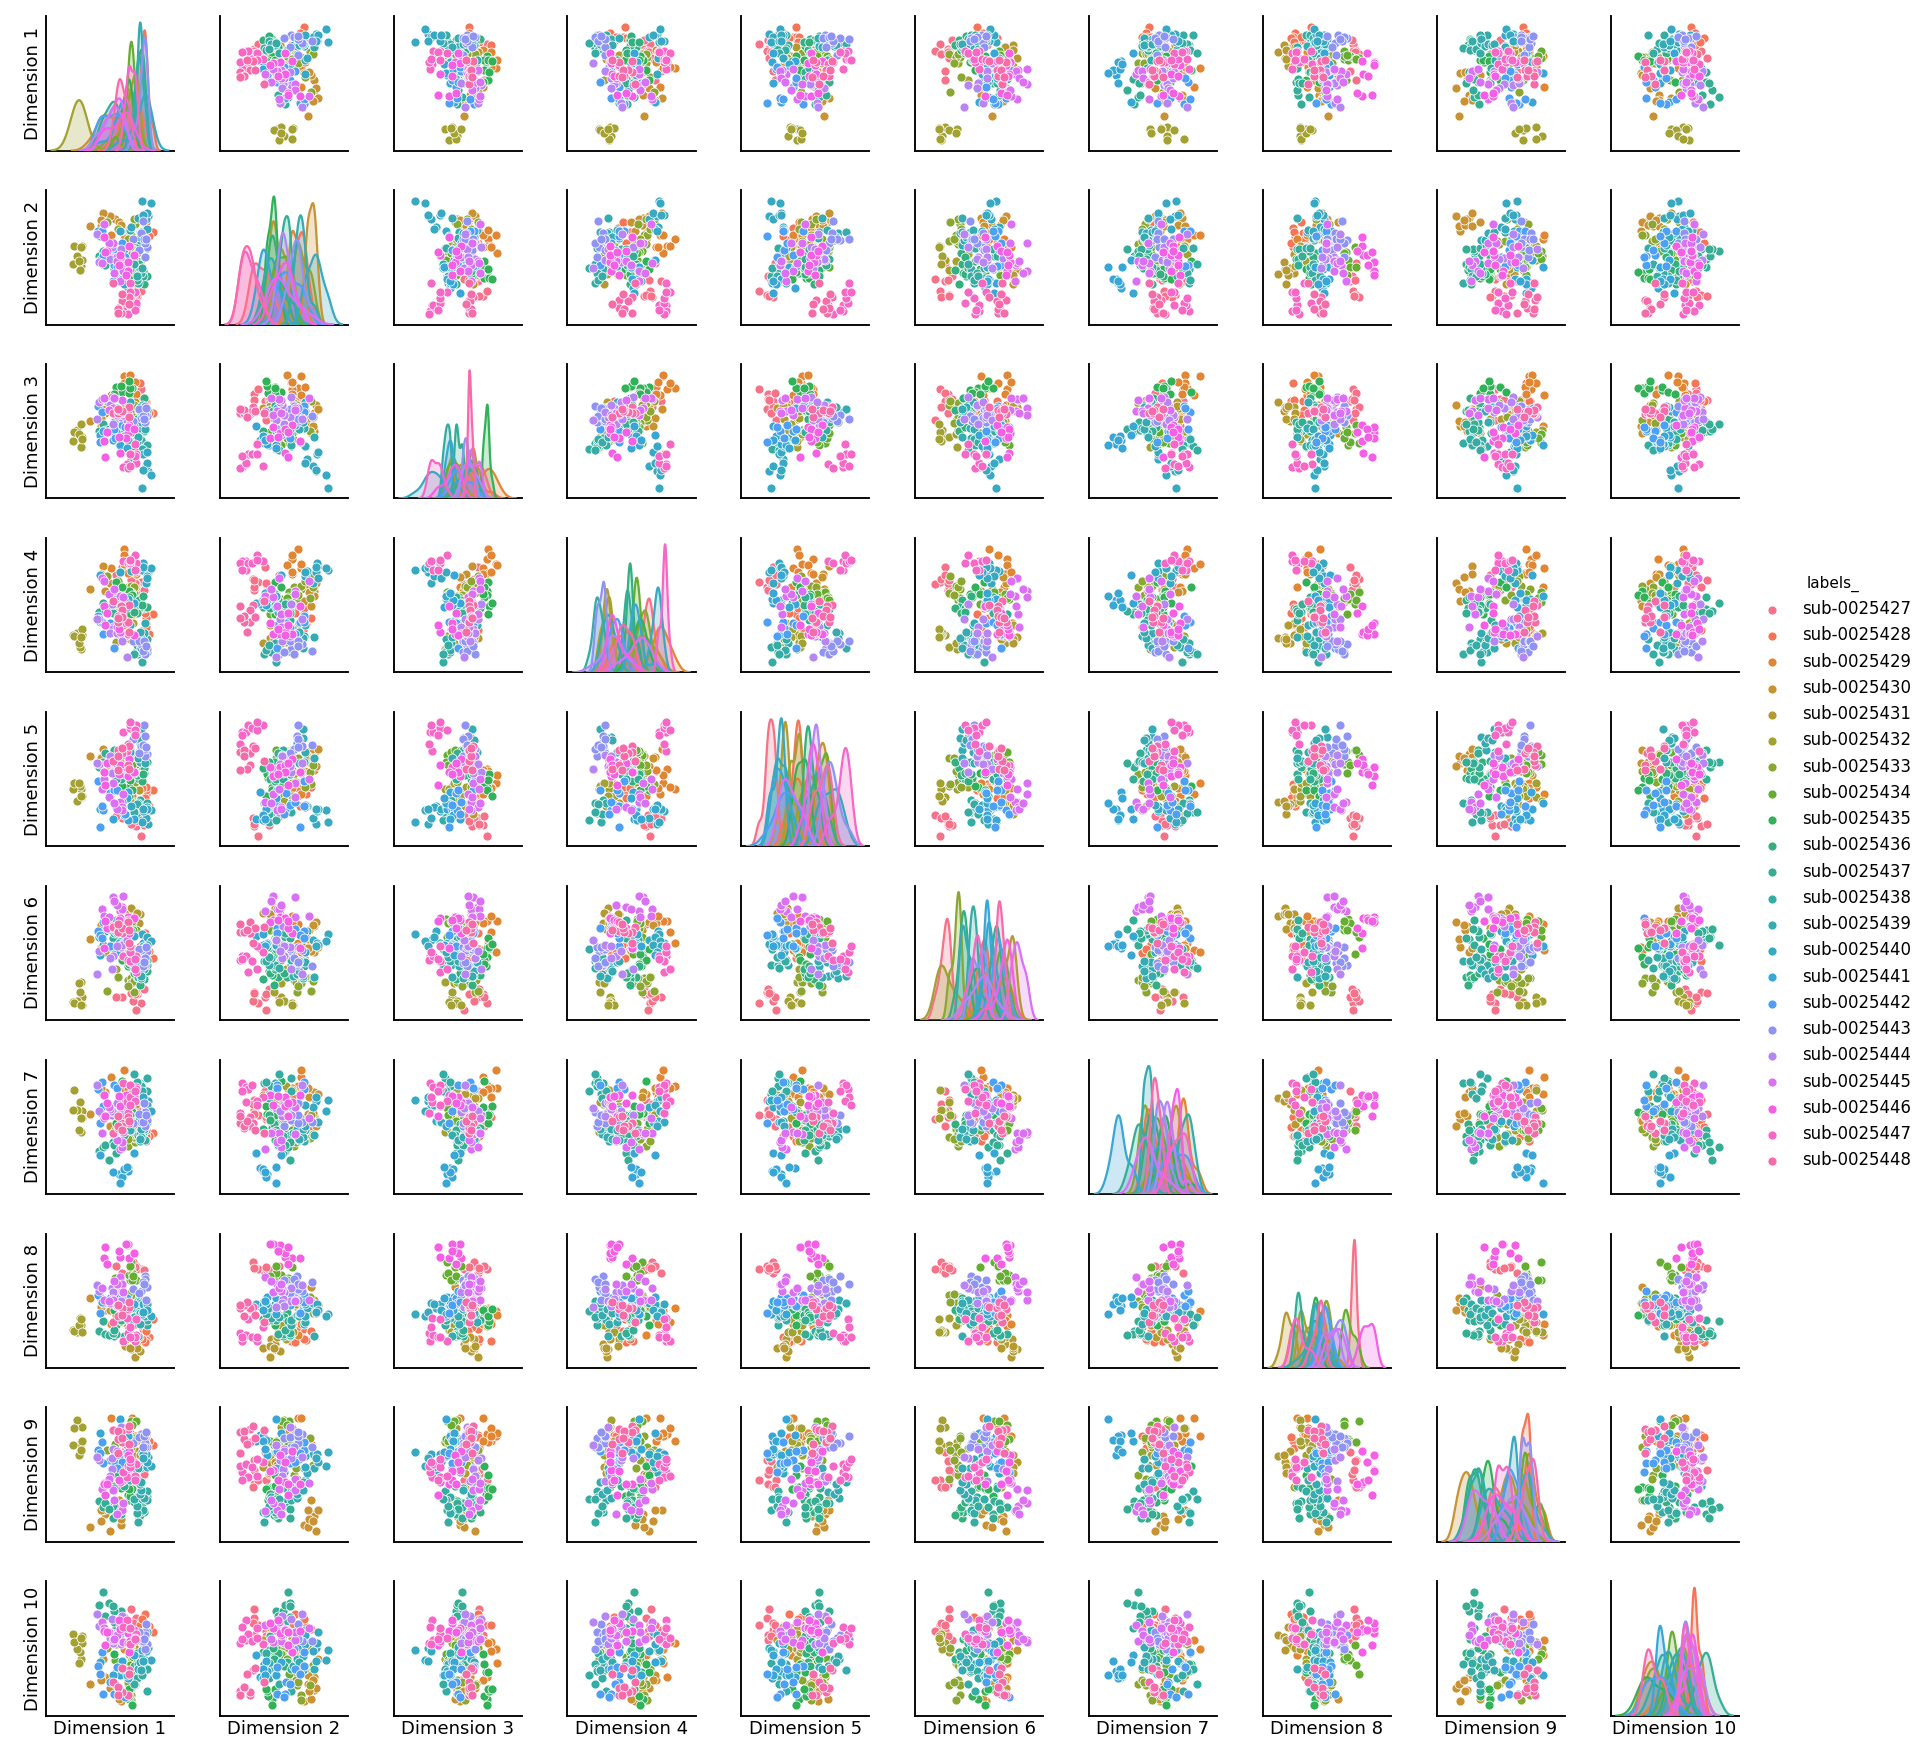

In [98]:
#df_labels = pd.DataFrame(y, columns=['labels'])
df_labels_ = pd.DataFrame(subject_labels[:220], columns=['labels_'])
col_names =  ['Dimension {}'.format(i) for i in range(1, X.shape[1] + 1)]
df = pd.DataFrame(X, columns = col_names)
df = pd.concat([df_labels_, df], axis = 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(15, 15))
    pairs = sns.pairplot(df, hue = 'labels_', vars=col_names[:10])
    pairs.set(xticklabels=[], yticklabels=[], yticks=[], xticks=[])

### ARI peaks at 0.981 when num_clusters = 22

There are 22 unique labels, each corresponding to each subject.

0.9814310113012827 23


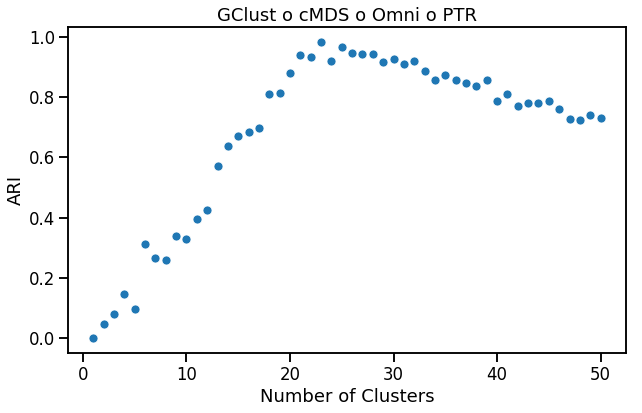

In [99]:
gclust = GaussianCluster(max_components = 50)
gclust.fit(X, subject_labels[:220])

aris = gclust.ari_
print(np.max(aris), np.argmax(aris) + 1)

with sns.plotting_context("talk", font_scale=1):
    fig = plt.figure(figsize=(10, 6))
    plot = sns.scatterplot(np.arange(1, len(aris) + 1), aris)
    plot.set(xlabel='Number of Clusters', ylabel='ARI', title='GClust o cMDS o Omni o PTR')